In [1]:
import numpy as np
import torch
import torch.nn as nn
import random

import transformers

from model import TrajectoryModel
from trajectory_gpt2 import GPT2Model

from matplotlib import pyplot as plt

import gymnasium as gym
import argparse
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading the trajectories from data

In [4]:
traj_states = torch.load("data/acrobot_states.pt")
traj_actions = torch.load("data/acrobot_actions.pt")
# traj_states.to(device)
# traj_actions.to(device)
state_dim  = traj_states.size()[2]
act_dim  = 1
n_traj = traj_states.size()[0]
traj_len = traj_states.size()[1]

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 12000000000 bytes. Error code 12 (Cannot allocate memory)

## Diving the data into Training and Testing set

In [36]:
train_traj_states = traj_states[0:int(0.95*n_traj),:,:]
train_traj_actions = traj_actions[0:int(0.95*n_traj),:]

n_train_traj = train_traj_states.size()[0]

test_traj_states = traj_states[int(0.95*n_traj):,:,:]
test_traj_actions = traj_actions[int(0.95*n_traj):,:]

n_test_traj = test_traj_states.size()[0]

## Function to obtain batch of trajectories

In [33]:
def get_batch(batch_size, n_traj, traj_states, traj_actions):
    idxs = random.choices(range(n_traj), k=batch_size)
    batch_states = traj_states[idxs,:,:]
    batch_actions = traj_actions[idxs,:]
    
    return batch_states, batch_actions.unsqueeze(-1)

## Decision Transformer Code

In [34]:
class DecisionTransformer(TrajectoryModel):

    """
    This model uses GPT to model (Return_1, state_1, action_1, Return_2, state_2, ...)
    """

    def __init__(
            self,
            state_dim,
            act_dim,
            hidden_size,
            max_length=None,
            max_ep_len=200,
            action_tanh=True,
            **kwargs
    ):
        super().__init__(state_dim, act_dim, max_length=max_length)

        self.hidden_size = hidden_size
        config = transformers.GPT2Config(
            vocab_size=1,  # doesn't matter -- we don't use the vocab
            n_embd=hidden_size,
            **kwargs
        )

        # note: the only difference between this GPT2Model and the default Huggingface version
        # is that the positional embeddings are removed (since we'll add those ourselves)
        self.transformer = GPT2Model(config)

        self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        #self.embed_return = torch.nn.Linear(1, hidden_size)
        self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

        self.embed_ln = nn.LayerNorm(hidden_size)

        # note: we don't predict states or returns for the paper
        self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(hidden_size, self.act_dim)] + ([nn.Tanh()] if action_tanh else []))
        )
        self.predict_return = torch.nn.Linear(hidden_size, 1)

    def forward(self, states, actions, timesteps, attention_mask=None):
        
        states = states.to(device)
        actions = actions.to(device)

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not

            # Create an attention mask tensor of shape (batch_size, seq_length, seq_length) with ones on the diagonal and below
            attention_mask = torch.ones((batch_size, seq_length), device = device, dtype=torch.long)
        
        ones_matrix = torch.triu(torch.ones(seq_length, seq_length)*float('-inf'), diagonal=1)
        encoder_attention_mask = ones_matrix.unsqueeze(0).repeat(batch_size, 1, 1)
        zeros_matrix = torch.zeros(batch_size, seq_length, seq_length)

        # embed each modality with a different head
        state_embeddings = self.embed_state(states)
        action_embeddings = self.embed_action(actions)
        #returns_embeddings = self.embed_return(returns_to_go)
        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = state_embeddings + time_embeddings
        action_embeddings = action_embeddings + time_embeddings
        #returns_embeddings = returns_embeddings + time_embeddings
        
        #print(state_embeddings.size())
        #print(action_embeddings.size())
        #print(returns_embeddings.size())
        
#         print(torch.stack(
#             (returns_embeddings, state_embeddings, action_embeddings), dim=1
#         ).size())

        # this makes the sequence look like (R_1, s_1, a_1, R_2, s_2, a_2, ...)
        # which works nice in an autoregressive sense since states predict actions
        stacked_inputs = torch.stack(
            (state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(batch_size, 2*seq_length, self.hidden_size)
        stacked_inputs = self.embed_ln(stacked_inputs)

        # to make the attention mask fit the stacked inputs, have to stack it as well
        stacked_attention_mask = torch.stack(
            (attention_mask, attention_mask), dim=1
        ).permute(0, 2, 1).reshape(batch_size, 2*seq_length)
        
        combined_mask_top = torch.cat([encoder_attention_mask, zeros_matrix], dim=2)
        combined_mask_bottom = torch.cat([zeros_matrix, encoder_attention_mask], dim=2)
        stacked_encoder_attention_mask = torch.cat([combined_mask_top, combined_mask_bottom], dim=1).to(device)
        

        # we feed in the input embeddings (not word indices as in NLP) to the model
        transformer_outputs = self.transformer(
            inputs_embeds=stacked_inputs,
            attention_mask=stacked_attention_mask,
            encoder_attention_mask = stacked_encoder_attention_mask
        )
        x = transformer_outputs['last_hidden_state']

        # reshape x so that the second dimension corresponds to the original
        # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
        x = x.reshape(batch_size, seq_length, 2, self.hidden_size).permute(0, 2, 1, 3)

        # get predictions
        #return_preds = self.predict_return(x[:,2])  # predict next return given state and action
        state_preds = self.predict_state(x[:,1])    # predict next state given state and action
        action_preds = self.predict_action(x[:,0])  # predict next action given state

        return state_preds, action_preds

    def get_state(self, states, actions, timesteps, **kwargs):
        # we don't care about the past rewards in this model

        states = states.reshape(1, -1, self.state_dim)
        actions = actions.reshape(1, -1, self.act_dim)
        timesteps = timesteps.reshape(1, -1)

        if self.max_length is not None:
            states = states[:,-self.max_length:]
            actions = actions[:,-self.max_length:]
            timesteps = timesteps[:,-self.max_length:]

            # pad all tokens to sequence length
            attention_mask = torch.cat([torch.zeros(self.max_length-states.shape[1]), torch.ones(states.shape[1])])
            attention_mask = attention_mask.to(dtype=torch.long, device=states.device).reshape(1, -1)
            states = torch.cat(
                [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
                dim=1).to(dtype=torch.float32)
            actions = torch.cat(
                [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                             device=actions.device), actions],
                dim=1).to(dtype=torch.float32)
            timesteps = torch.cat(
                [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
                dim=1
            ).to(dtype=torch.long)
        else:
            attention_mask = None

        state_preds, action_preds = self.forward(
            states, actions, timesteps, attention_mask=attention_mask, **kwargs)
        
#         print(state_preds.size())
#         print(state_preds[0,-1].size())

        return state_preds[0,-1]

In [35]:
model = DecisionTransformer(
            state_dim=state_dim,
            act_dim=act_dim,
            max_length=20,
            max_ep_len=200,
            hidden_size=128,
            n_layer=3,
            n_head=4,
            n_inner=4*128,
            activation_function='relu',
            n_positions=1024,
            resid_pdrop=0.1,
            attn_pdrop=0.1,
            n_ctx=600
        )

## Training

In [19]:
model.to(device)
batch_size = 64
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.1,
    weight_decay=1e-4,
)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda steps: min((steps+1)/10000, 1)
)

n_epochs = 600

train_losses = torch.zeros(n_epochs)

for n in range(n_epochs):
    state_batch, action_batch = get_batch(batch_size, n_train_traj, train_traj_states, train_traj_actions)

    state_pred, action_preds = model.forward(state_batch, action_batch, (torch.arange(0,traj_len,1).unsqueeze(0)).to(device))

    loss = nn.MSELoss()
    l = loss(state_pred,state_batch.to(device))
    train_losses[n] = l.detach().cpu().item()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()

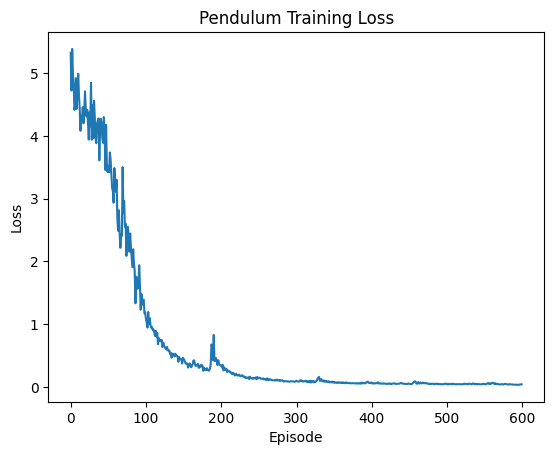

In [44]:
plt.plot(losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Pendulum Training Loss")
plt.savefig("figures/pendulum_training_loss.pdf")

In [22]:
model.eval()

n_eval = 100
eval_losses = torch.zeros(n_eval)

for n in range(n_eval):

    states_i, actions_i = get_batch(1, n_traj, traj_states, traj_actions)

    state = states_i[0,0,:]
    action = actions_i[0,0,:]

    # we keep all the histories on the device
    # note that the latest action and reward will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    #rewards = torch.zeros(0, device=device, dtype=torch.float32)
    #target_return = torch.tensor(target_return, device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(199):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        #rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_i[0,t+1].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
    loss = nn.MSELoss()
    l = loss(states.unsqueeze(0),states_i.to(device))
    eval_losses[n] = l.detach().cpu().item()

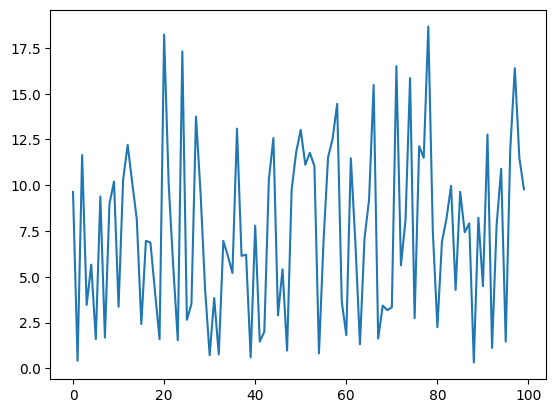

In [23]:
plt.plot(eval_losses)

In [24]:
model.eval()

n_eval = 1
eval_losses = torch.zeros(199)

for n in range(n_eval):

    states_i, actions_i = get_batch(1, n_traj, traj_states, traj_actions)

    state = states_i[0,0,:]
    action = actions_i[0,0,:]

    # we keep all the histories on the device
    # note that the latest action and reward will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    #rewards = torch.zeros(0, device=device, dtype=torch.float32)
    #target_return = torch.tensor(target_return, device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(199):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        #rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_i[0,t+1].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
#         print(states.size())
#         print(states_i[0,0:t+2,:].size())
        
        loss = nn.MSELoss()
        l = loss(states,(states_i[0,0:t+2,:]).to(device))
        eval_losses[t] = l.detach().cpu().item()

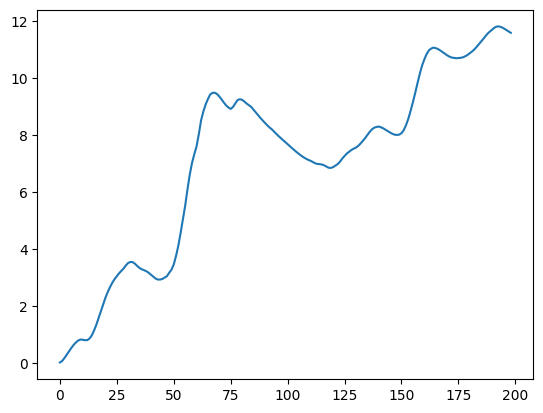

In [25]:
plt.plot(eval_losses)

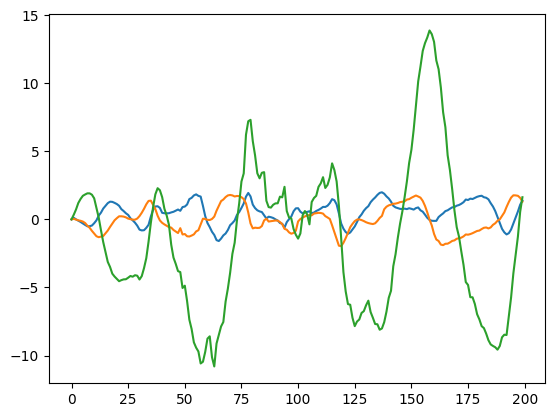

In [26]:
diff = states_i - states.to('cpu')
diff = diff.detach().numpy()
plt.plot(diff[0,:,0])
plt.plot(diff[0,:,1])
plt.plot(diff[0,:,2])